In [1]:
import pandas as pd
from database.market import Market
from datetime import datetime,timedelta
from parameters.parameters import Parameters
from backtester.backtester_lite import BacktesterLite
from processor.processor import Processor as p
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

In [2]:
market = Market()

In [3]:
market.connect()
sp500 = market.retrieve("sp500")
sp100 = market.retrieve("sp100")
market.disconnect()

In [4]:
start_date = datetime.now() - timedelta(days=7*365.25)
end_date = datetime.now()
lookbacks = [5]
holding_periods = [1]
floors = [-10,0]
ceilings = [1,10]
local_min = [False]
volatilities = [0.5,1]
positions = 11
tickers = sp500["ticker"]
asset = "stocks"

In [5]:
parameters = Parameters.parameters_lite(lookbacks,holding_periods,ceilings,floors,volatilities,local_min)

In [6]:
len(parameters)

256

In [7]:
simulation = []
market.connect()
for ticker in tqdm(tickers):
    try:
        ticker_data = market.retrieve_ticker_prices(asset,ticker)
        ticker_data = p.column_date_processing(ticker_data)
        ticker_data.sort_values("date",inplace=True)
        ticker_data["week"] = [x.week for x in ticker_data["date"]]
        ticker_data["day"] = [x.weekday() for x in ticker_data["date"]]
        ticker_data["prev_close"] = ticker_data["adjclose"].shift(1)
        for lookback in lookbacks:
            ticker_data[f"window_{lookback}"] = ticker_data["prev_close"].shift(lookback)
            ticker_data[f"rolling_{lookback}"] = ticker_data["prev_close"].rolling(lookback).mean()
            ticker_data["d1"] = ticker_data[f"adjclose"].pct_change()
            ticker_data[f"rolling_stdev_{lookback}"] = ticker_data["prev_close"].rolling(lookback).std()
            ticker_data[f"rolling_pct_stdev_{lookback}"] = ticker_data[f"rolling_stdev_{lookback}"] / ticker_data[f"rolling_{lookback}"]
        for holding_period in holding_periods:
            ticker_data[f"return_{holding_period}"] = (ticker_data["adjclose"].shift(-holding_period) - ticker_data["adjclose"]) / ticker_data["adjclose"]
        simulation.append(ticker_data.dropna())
    except Exception as e:
        print(ticker,str(e))
market.disconnect()
final = pd.concat(simulation)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:12<00:00, 41.78it/s]


In [8]:
final = pd.concat(simulation).merge(sp500[["ticker","GICS Sector"]],how="left")

In [9]:
all_trades = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        trades = BacktesterLite.backtest(positions,sp100,final.copy(),iteration,parameter,False)
        all_trades.append(trades)
    except Exception as e:
        print(str(e))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [03:23<00:00,  1.26it/s]


In [10]:
analysis = pd.concat(all_trades)
analysis["return"] = analysis["return"] + 1

In [11]:
report = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        iteration_trades = analysis[analysis["iteration"]==iteration]
        iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
        cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
        for i in range(positions):
            if float(i) not in cumulative.columns:
                cumulative[float(i)] = 1
        cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
        iter_report = cumulative.cumprod().iloc[-1]
        for key in parameter.keys():
            iter_report[key] = parameter[key]
        iter_report["iteration"] = iteration
        report.append(iter_report[["pv","iteration"] + list(parameter.keys())])
    except Exception as e:
        print(str(e))
        continue

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:31<00:00,  8.11it/s]


In [12]:
iteration_trades

,date,ticker,signal,return,position,iteration,strategy,value,lookback,holding_period,floor,ceiling,volatility,local_min,industry_weighted,weekend,constituent
1914,2016-08-18 04:00:00,TXN,-0.001003,1.001996,0,255,window,False,5,1,0,10,1.0,False,False,False,500
1915,2016-08-18 04:00:00,CBOE,-0.000733,0.993735,1,255,window,False,5,1,0,10,1.0,False,False,False,500
1916,2016-08-18 04:00:00,PAYX,-0.000673,1.005348,2,255,window,False,5,1,0,10,1.0,False,False,False,500
1917,2016-08-18 04:00:00,LHX,-0.000667,1.003310,3,255,window,False,5,1,0,10,1.0,False,False,False,500
1918,2016-08-18 04:00:00,LEN,-0.000641,0.991894,4,255,window,False,5,1,0,10,1.0,False,False,False,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21253,2023-08-16 04:00:00,GWW,-0.000842,0.991597,1,255,window,False,5,1,0,10,1.0,False,False,False,500
21254,2023-08-16 04:00:00,ZTS,-0.000793,0.981210,2,255,window,False,5,1,0,10,1.0,False,False,False,500
21255,2023-08-16 04:00:00,IDXX,-0.000766,0.973716,3,255,window,False,5,1,0,10,1.0,False,False,False,500
21256,2023-08-16 04:00:00,COP,-0.000693,1.018231,4,255,window,False,5,1,0,10,1.0,False,False,False,500


In [13]:
performance = pd.DataFrame(report)

In [14]:
performance.sort_values("pv",ascending=False).head(20)

position,pv,iteration,strategy,value,lookback,holding_period,floor,ceiling,volatility,local_min,industry_weighted,weekend,constituent
1405,10.981211,200,window,True,5,1,0,1,0.5,False,True,True,500
1405,10.981211,204,window,True,5,1,0,1,1.0,False,True,True,500
1405,9.925939,216,window,True,5,1,0,10,0.5,False,True,True,500
1405,9.884738,220,window,True,5,1,0,10,1.0,False,True,True,500
1759,9.200112,201,window,True,5,1,0,1,0.5,False,True,False,500
1759,9.200112,205,window,True,5,1,0,1,1.0,False,True,False,500
1405,8.863591,196,window,True,5,1,-10,1,1.0,False,True,True,500
1405,8.863591,192,window,True,5,1,-10,1,0.5,False,True,True,500
1759,8.449787,217,window,True,5,1,0,10,0.5,False,True,False,500
1759,8.423461,221,window,True,5,1,0,10,1.0,False,True,False,500


In [15]:
iteration = performance.sort_values("pv",ascending=False).iloc[0]["iteration"]
parameter = parameters[iteration]
iteration_trades = analysis[analysis["iteration"]==iteration]
iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
cumulative["pv"] = cumulative["pv"].cumprod()

In [16]:
# cumulative

position,date,0,1,2,3,4,5,6,7,8,9,10,pv
0,2016-08-18 04:00:00,0.982528,1.003875,1.002757,0.999343,1.011456,1.078751,1.001014,NaN,0.984089,0.997440,1.006542,NaN
1,2016-08-22 04:00:00,0.998382,1.196037,1.004296,1.000000,1.009376,1.002794,0.993309,1.011043,1.011255,0.995483,0.986573,1.018959
2,2016-08-23 04:00:00,0.923523,0.985638,1.000648,0.942110,1.009571,0.987397,0.998503,1.001085,0.998201,0.995670,0.996250,1.004008
3,2016-08-24 04:00:00,1.004859,1.004349,0.995815,0.998256,1.006627,0.987174,0.992004,0.998735,0.996967,1.007779,1.010485,1.004286
4,2016-08-25 04:00:00,0.996016,1.003269,1.004843,1.005710,0.985744,0.994273,0.992708,0.992568,1.006240,1.006986,0.997216,1.002969
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,2023-08-09 04:00:00,1.012415,1.001187,0.991847,1.008964,1.017892,1.000910,0.991600,1.000000,0.989311,1.002871,0.979216,11.284897
1402,2023-08-10 04:00:00,0.980092,0.979926,1.013211,1.015966,1.007897,1.016731,1.004653,1.012567,0.992351,0.982782,1.006323,11.297719
1403,2023-08-14 04:00:00,1.003475,1.004274,0.978516,0.995499,0.993997,0.978127,0.998649,0.986152,0.998035,0.983178,0.987551,11.202668
1404,2023-08-15 04:00:00,0.975277,0.989662,0.961293,0.970048,0.980799,0.986379,1.022778,0.985936,0.988593,0.979284,0.990797,11.030397


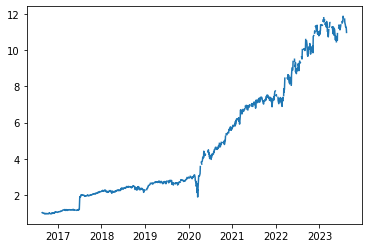

In [17]:
# plt.plot(cumulative["date"],cumulative["pv"])

In [18]:
pd.DataFrame([parameter]).to_csv("parameter.csv")